# PROBLEM STATEMENT:

The task involves developing predictive models to estimate consumer liking distributions for a set of products based on their sensory profiles. The sensory data provides descriptions of the products, and the overall liking scores, ranging from 1 to 9, represent consumer preferences.

**Objectives**:The goal is to build effective models that can accurately predict the overall consumer liking distributions for each product using Python libraries.

# Import libraries

In [1]:
#installing pyxlsb for extracting data in pyxlsb file
!pip install pyxlsb

In [10]:
#importing necessary libraries
import pandas as pd
from pyxlsb import open_workbook
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from scipy.stats import zscore

# Data Collection And Cleaning

In [14]:
xlsb_path = "C:/Users/NMESOMA/Downloads/Data.xlsb.xlsb"

In [15]:
# Defining  function to extract data from  sheet and returning  a DataFrame
def sheet_to_dataframe(sheet):
    data = [row for row in sheet.rows()]
    columns = [cell.v for cell in data[0]]
    rows = [[cell.v for cell in row] for row in data[1:]]
    df = pd.DataFrame(rows, columns=columns)
    return df

In [16]:
# Opening  workbook
with open_workbook(xlsb_path) as wb:
    # Access the desired sheet by name (e.g., 'Sensory' and 'Overall Liking')
    sensory_sheet = wb.get_sheet('Sensory')
    liking_sheet = wb.get_sheet('Overall Liking')

    # Convert each sheet to a Pandas DataFrame
    sensory_df = sheet_to_dataframe(sensory_sheet)
    liking_df = sheet_to_dataframe(liking_sheet)

In [17]:
sensory_df.head()

,Prod,sweet,sour,bitter,aromatic.impact,fruity.impact,art.sweetener.chewing,chews,art.sweetener.after,stickiness.with.fingers,...,hardness.with.molars,uniformity.of.bite,gritty,springiness.during.chew,cohesiveness.of.mass,moistness.of.mass,toothsticking,toothpacking,adhesiveness.to.molars,oily.mouthcoating
0,product 1,8.072222,4.455556,1.894444,7.208333,5.441667,1.483333,21.130556,1.136111,8.105556,...,6.622222,12.244444,2.227778,8.794444,8.877778,13.322222,8.111111,3.250000,5.066667,4.488889
1,product 2,7.868421,2.626316,1.468421,6.581579,5.063158,0.810526,20.473684,0.763158,3.105263,...,6.421053,12.847368,0.005263,8.384211,8.136842,13.136842,6.815789,3.136842,4.226316,4.084211
2,product 3,7.813158,2.439474,1.502632,6.292105,4.581579,2.076316,24.547368,2.028947,1.136842,...,10.557895,13.610526,0.189474,11.457895,7.257895,13.415789,6.263158,1.936842,2.594737,4.073684
3,product 4,9.776316,3.778947,1.702632,8.260526,6.539474,1.626316,26.071053,1.326316,4.657895,...,9.457895,13.184211,0.005263,10.726316,7.505263,13.900000,6.231579,2.189474,2.700000,4.089474
4,product 5,7.825000,2.886111,1.852778,6.441667,4.894444,1.438889,21.141667,1.427778,4.761111,...,9.488889,14.027778,0.005556,9.344444,8.516667,13.377778,8.088889,5.466667,6.438889,3.844444


In [18]:
liking_df.head()

,iobs,product 1,product 2,product 3,product 4,product 5,product 6,product 7,product 8,product 9,...,None,None,None,None,None,None,None,None,None,None
0,11001.0,1.0,8.0,2.0,6.0,2.0,5.0,1.0,9.0,8.0,...,None,None,None,None,None,None,None,None,None,None
1,11002.0,3.0,6.0,3.0,8.0,6.0,4.0,6.0,3.0,7.0,...,None,None,None,None,None,None,None,None,None,None
2,11003.0,3.0,9.0,9.0,9.0,1.0,1.0,7.0,1.0,1.0,...,None,None,None,None,None,None,None,None,None,None
3,11004.0,4.0,7.0,6.0,8.0,6.0,6.0,5.0,2.0,7.0,...,None,None,None,None,None,None,None,None,None,None
4,11005.0,5.0,8.0,2.0,8.0,7.0,3.0,8.0,4.0,7.0,...,None,None,None,None,None,None,None,None,None,None


In [19]:
# sensory data exploration
sensory_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Prod                      14 non-null     object 
 1   sweet                     14 non-null     float64
 2   sour                      14 non-null     float64
 3   bitter                    14 non-null     float64
 4   aromatic.impact           14 non-null     float64
 5   fruity.impact             14 non-null     float64
 6   art.sweetener.chewing     14 non-null     float64
 7   chews                     14 non-null     float64
 8   art.sweetener.after       14 non-null     float64
 9   stickiness.with.fingers   14 non-null     float64
 10  springiness.with.fingers  14 non-null     float64
 11  abrasive                  14 non-null     float64
 12  hardness.with.molars      14 non-null     float64
 13  uniformity.of.bite        14 non-null     float64
 14  gritty      

In [20]:
# summary statistics of the sensory data
sensory_df.describe()

,sweet,sour,bitter,aromatic.impact,fruity.impact,art.sweetener.chewing,chews,art.sweetener.after,stickiness.with.fingers,springiness.with.fingers,...,hardness.with.molars,uniformity.of.bite,gritty,springiness.during.chew,cohesiveness.of.mass,moistness.of.mass,toothsticking,toothpacking,adhesiveness.to.molars,oily.mouthcoating
count,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,...,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000
mean,8.171836,3.434962,1.750929,6.909221,5.209273,1.669622,23.208939,1.575052,4.158459,9.006746,...,8.322118,13.140351,0.611905,9.087928,8.609106,13.211821,7.542251,4.541124,5.568588,4.055075
std,1.042356,1.100902,0.274194,0.706022,0.705760,0.583197,3.115673,0.570227,1.849573,1.944932,...,1.685099,0.578168,1.548145,1.557960,1.241507,0.495514,1.575484,2.562140,2.784373,0.489501
min,6.363889,2.163889,1.444444,6.088889,4.480556,0.480556,19.408333,0.583333,1.136842,6.038889,...,6.355556,12.155556,0.000000,6.977778,6.994444,12.055556,5.161111,1.827778,2.366667,2.900000
25%,7.757895,2.691265,1.605885,6.329496,4.624379,1.403801,20.637902,1.304605,2.922149,7.769444,...,6.700000,12.691009,0.005263,7.843056,7.533114,12.917544,6.239474,2.143202,2.704167,3.901754
50%,7.846711,3.137500,1.729094,6.701389,4.978801,1.717325,21.991667,1.540278,4.420614,8.906871,...,8.047222,13.263889,0.030556,8.834064,8.647222,13.350000,8.100000,4.122222,5.752778,4.086842
75%,8.621528,4.075987,1.821528,7.270833,5.506250,2.027376,25.959539,1.979349,5.108772,11.060892,...,9.481140,13.610965,0.178216,10.402778,9.267982,13.495833,8.502412,5.780921,7.189108,4.356944
max,10.097222,6.250000,2.563889,8.260526,6.625000,2.569444,28.375000,2.716667,8.105556,11.300000,...,10.794444,14.027778,5.594444,11.522222,11.127778,13.900000,10.227778,9.044444,10.372222,4.733333


In [22]:
# Checking data Size
sensory_df.shape

(14, 22)

In [21]:
#checking for missing values
sensory_df.isnull().sum()

Prod                        0
sweet                       0
sour                        0
bitter                      0
aromatic.impact             0
fruity.impact               0
art.sweetener.chewing       0
chews                       0
art.sweetener.after         0
stickiness.with.fingers     0
springiness.with.fingers    0
abrasive                    0
hardness.with.molars        0
uniformity.of.bite          0
gritty                      0
springiness.during.chew     0
cohesiveness.of.mass        0
moistness.of.mass           0
toothsticking               0
toothpacking                0
adhesiveness.to.molars      0
oily.mouthcoating           0
dtype: int64

In [23]:
#exploration of the overall liking data
liking_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 34 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   iobs        301 non-null    float64
 1   product 1   302 non-null    float64
 2   product 2   302 non-null    object 
 3   product 3   302 non-null    float64
 4   product 4   302 non-null    float64
 5   product 5   302 non-null    float64
 6   product 6   302 non-null    float64
 7   product 7   302 non-null    float64
 8   product 8   301 non-null    float64
 9   product 9   302 non-null    float64
 10  product 10  302 non-null    float64
 11  product 11  302 non-null    float64
 12  product 12  302 non-null    float64
 13  product 13  302 non-null    float64
 14  product 14  301 non-null    float64
 15  None        0 non-null      object 
 16  None        0 non-null      object 
 17  None        0 non-null      object 
 18  None        0 non-null      object 
 19  None        0 non-null      o

In [24]:
#Summary statistics  for liking data
liking_df.describe()

,iobs,product 1,product 3,product 4,product 5,product 6,product 7,product 8,product 9,product 10,product 11,product 12,product 13,product 14
count,301.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,301.000000,302.000000,302.000000,302.000000,302.000000,302.000000,301.000000
mean,16160.036545,5.490066,5.506623,7.476821,5.685430,5.556291,5.788079,4.684385,6.688742,4.347682,5.344371,7.059603,5.675497,6.056478
std,5009.515392,2.215522,2.243845,1.772190,2.172859,2.247585,2.220740,2.318776,1.712512,2.471427,2.369648,1.769929,2.204042,2.149449
min,11001.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,11076.000000,4.000000,4.000000,7.000000,4.000000,4.000000,4.000000,3.000000,6.000000,2.000000,3.000000,6.000000,4.000000,5.000000
50%,21003.000000,6.000000,6.000000,8.000000,6.000000,6.000000,6.000000,4.000000,7.000000,4.000000,6.000000,8.000000,6.000000,7.000000
75%,21080.000000,7.000000,7.000000,9.000000,7.000000,7.000000,8.000000,7.000000,8.000000,7.000000,7.000000,8.000000,7.000000,8.000000
max,21155.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,11.000000,9.000000,9.000000,9.000000


In [25]:
liking_df.shape

(302, 34)

In [26]:
#checking for missing values
liking_df.isnull().sum()

iobs            1
product 1       0
product 2       0
product 3       0
product 4       0
product 5       0
product 6       0
product 7       0
product 8       1
product 9       0
product 10      0
product 11      0
product 12      0
product 13      0
product 14      1
None          302
None          302
None          302
None          302
None          302
None          302
None          302
None          302
None          302
None          302
None          302
None          302
None          302
None          302
None          302
None          302
None          302
None          302
None          301
dtype: int64

In [29]:
# dropping the none columns and rows
liking_data = liking_df.iloc[:, :15]


In [30]:
#showing the first few rows of the cleaned liking data

liking_data.head()

,iobs,product 1,product 2,product 3,product 4,product 5,product 6,product 7,product 8,product 9,product 10,product 11,product 12,product 13,product 14
0,11001.0,1.0,8.0,2.0,6.0,2.0,5.0,1.0,9.0,8.0,1.0,1.0,7.0,9.0,6.0
1,11002.0,3.0,6.0,3.0,8.0,6.0,4.0,6.0,3.0,7.0,7.0,3.0,7.0,2.0,5.0
2,11003.0,3.0,9.0,9.0,9.0,1.0,1.0,7.0,1.0,1.0,6.0,2.0,2.0,1.0,9.0
3,11004.0,4.0,7.0,6.0,8.0,6.0,6.0,5.0,2.0,7.0,7.0,4.0,8.0,3.0,8.0
4,11005.0,5.0,8.0,2.0,8.0,7.0,3.0,8.0,4.0,7.0,1.0,6.0,7.0,6.0,6.0


In [35]:
# filling in missing value in the overall liking data
liking_data['iobs'].fillna(liking_data['iobs'].mean(), inplace=True)
liking_data['product 8'].fillna(liking_data['product 8'].mean(), inplace=True)
liking_data['product 14'].fillna(liking_data['product 14'].mean(), inplace=True)

liking_data.isnull().sum()

iobs          0
product 1     0
product 2     0
product 3     0
product 4     0
product 5     0
product 6     0
product 7     0
product 8     0
product 9     0
product 10    0
product 11    0
product 12    0
product 13    0
product 14    0
dtype: int64

In [43]:
product_dtype = liking_data['product 2'].dtype
print(f"The data type of 'product 2' is: {product_dtype}")


The data type of 'product 2' is: object


In [44]:
value_counts = liking_data['product 2'].value_counts()
print(f"Value counts in 'product 2':\n{value_counts}")

Value counts in 'product 2':
8.0    83
7.0    68
9.0    55
6.0    47
4.0    17
5.0    13
3.0    11
2.0     7
e       1
Name: product 2, dtype: int64


In [45]:
# Converting 'product 2' column to numeric, coerce non-numeric values to NaN
liking_data['product 2'] = pd.to_numeric(liking_data['product 2'], errors='coerce')

# Impute missing values with the mean
mean_value = liking_data['product 2'].mean()
liking_data['product 2'].fillna(mean_value, inplace=True)

# Print the data type after imputation
print(f"The data type of 'product 2' after imputation: {liking_data['product 2'].dtype}")



The data type of 'product 2' after imputation: float64


In [46]:
# joining dataframes along the row axis (axis=0)
merged_data = pd.concat([sensory_df, liking_data], axis=1)
merged_data.head(20)    

,Prod,sweet,sour,bitter,aromatic.impact,fruity.impact,art.sweetener.chewing,chews,art.sweetener.after,stickiness.with.fingers,...,product 5,product 6,product 7,product 8,product 9,product 10,product 11,product 12,product 13,product 14
0,product 1,8.072222,4.455556,1.894444,7.208333,5.441667,1.483333,21.130556,1.136111,8.105556,...,2.0,5.0,1.0,9.0,8.0,1.0,1.0,7.0,9.0,6.0
1,product 2,7.868421,2.626316,1.468421,6.581579,5.063158,0.810526,20.473684,0.763158,3.105263,...,6.0,4.0,6.0,3.0,7.0,7.0,3.0,7.0,2.0,5.0
2,product 3,7.813158,2.439474,1.502632,6.292105,4.581579,2.076316,24.547368,2.028947,1.136842,...,1.0,1.0,7.0,1.0,1.0,6.0,2.0,2.0,1.0,9.0
3,product 4,9.776316,3.778947,1.702632,8.260526,6.539474,1.626316,26.071053,1.326316,4.657895,...,6.0,6.0,5.0,2.0,7.0,7.0,4.0,8.0,3.0,8.0
4,product 5,7.825000,2.886111,1.852778,6.441667,4.894444,1.438889,21.141667,1.427778,4.761111,...,7.0,3.0,8.0,4.0,7.0,1.0,6.0,7.0,6.0,6.0
5,product 6,7.739474,2.894737,1.592105,6.192105,4.528947,1.392105,19.855263,1.318421,4.868421,...,6.0,6.0,6.0,3.0,6.0,7.0,3.0,7.0,4.0,7.0
6,product 7,7.505556,3.686111,1.794444,6.263889,4.752778,1.819444,21.888889,1.830556,3.388889,...,4.0,2.0,4.0,6.0,7.0,1.0,3.0,8.0,6.0,1.0
7,product 8,7.819444,2.250000,1.830556,6.088889,4.480556,2.569444,26.866667,2.033333,5.555556,...,8.0,7.0,7.0,4.0,6.0,9.0,8.0,7.0,6.0,7.0
8,product 9,9.477778,3.255556,1.444444,7.291667,5.700000,1.880556,25.625000,1.652778,5.188889,...,7.0,9.0,2.0,6.0,2.0,4.0,3.0,9.0,7.0,6.0
9,product 10,6.363889,6.250000,2.563889,6.738889,4.833333,2.216667,20.186111,2.716667,2.327778,...,6.0,3.0,6.0,4.0,7.0,3.0,3.0,8.0,8.0,3.0


In [47]:
merged_data.shape

(302, 37)

In [48]:
merged_data.isnull().sum()

Prod                        288
sweet                       288
sour                        288
bitter                      288
aromatic.impact             288
fruity.impact               288
art.sweetener.chewing       288
chews                       288
art.sweetener.after         288
stickiness.with.fingers     288
springiness.with.fingers    288
abrasive                    288
hardness.with.molars        288
uniformity.of.bite          288
gritty                      288
springiness.during.chew     288
cohesiveness.of.mass        288
moistness.of.mass           288
toothsticking               288
toothpacking                288
adhesiveness.to.molars      288
oily.mouthcoating           288
iobs                          0
product 1                     0
product 2                     0
product 3                     0
product 4                     0
product 5                     0
product 6                     0
product 7                     0
product 8                     0
product 

In [57]:
# i will handle the missing values in sensory feature because its what i will use to predict the target variables
# it wont be okay, in my opinion to remove all rows missing
#or cut down  the liking data to align with the sensory data, so that my models can predict well


merged_data['sweet'].fillna(merged_data['sweet'].mean(), inplace=True)
merged_data['sour'].fillna(merged_data['sour'].mean(), inplace=True)
merged_data['bitter'].fillna(merged_data['bitter'].mean(), inplace=True)
merged_data['aromatic.impact'].fillna(merged_data['aromatic.impact'].mean(), inplace=True)
merged_data['fruity.impact'].fillna(merged_data['fruity.impact'].mean(), inplace=True)
merged_data['art.sweetener.chewing'].fillna(merged_data['art.sweetener.chewing'].mean(), inplace=True)
merged_data['chews'].fillna(merged_data['chews'].mean(), inplace=True)
merged_data['art.sweetener.after'].fillna(merged_data['art.sweetener.after'].mean(), inplace=True)
merged_data['stickiness.with.fingers'].fillna(merged_data['stickiness.with.fingers'].mean(), inplace=True)
merged_data['springiness.with.fingers'].fillna(merged_data['springiness.with.fingers'].mean(), inplace=True)
merged_data['abrasive'].fillna(merged_data['abrasive'].mean(), inplace=True)
merged_data['hardness.with.molars'].fillna(merged_data['hardness.with.molars'].mean(), inplace=True)
merged_data['uniformity.of.bite'].fillna(merged_data['uniformity.of.bite'].mean(), inplace=True)
merged_data['gritty'].fillna(merged_data['gritty'].mean(), inplace=True)
merged_data['springiness.during.chew'].fillna(merged_data['springiness.during.chew'].mean(), inplace=True)
merged_data['cohesiveness.of.mass'].fillna(merged_data['cohesiveness.of.mass'].mean(), inplace=True)
merged_data['moistness.of.mass'].fillna(merged_data['moistness.of.mass'].mean(), inplace=True)
merged_data['toothsticking'].fillna(merged_data['toothsticking'].mean(), inplace=True)
merged_data['toothpacking'].fillna(merged_data['toothpacking'].mean(), inplace=True)
merged_data['adhesiveness.to.molars'].fillna(merged_data['adhesiveness.to.molars'].mean(), inplace=True)
merged_data['oily.mouthcoating'].fillna(merged_data['oily.mouthcoating'].mean(), inplace=True)

#drop prod and iobs columns
merged_data.drop(['iobs','Prod'], axis=1, inplace=True)

merged_data.head()
     

,sweet,sour,bitter,aromatic.impact,fruity.impact,art.sweetener.chewing,chews,art.sweetener.after,stickiness.with.fingers,springiness.with.fingers,...,product 5,product 6,product 7,product 8,product 9,product 10,product 11,product 12,product 13,product 14
0,8.072222,4.455556,1.894444,7.208333,5.441667,1.483333,21.130556,1.136111,8.105556,9.061111,...,2.0,5.0,1.0,9.0,8.0,1.0,1.0,7.0,9.0,6.0
1,7.868421,2.626316,1.468421,6.581579,5.063158,0.810526,20.473684,0.763158,3.105263,9.321053,...,6.0,4.0,6.0,3.0,7.0,7.0,3.0,7.0,2.0,5.0
2,7.813158,2.439474,1.502632,6.292105,4.581579,2.076316,24.547368,2.028947,1.136842,11.121053,...,1.0,1.0,7.0,1.0,1.0,6.0,2.0,2.0,1.0,9.0
3,9.776316,3.778947,1.702632,8.260526,6.539474,1.626316,26.071053,1.326316,4.657895,11.105263,...,6.0,6.0,5.0,2.0,7.0,7.0,4.0,8.0,3.0,8.0
4,7.825000,2.886111,1.852778,6.441667,4.894444,1.438889,21.141667,1.427778,4.761111,8.461111,...,7.0,3.0,8.0,4.0,7.0,1.0,6.0,7.0,6.0,6.0


In [58]:
merged_data.isnull().sum()

sweet                       0
sour                        0
bitter                      0
aromatic.impact             0
fruity.impact               0
art.sweetener.chewing       0
chews                       0
art.sweetener.after         0
stickiness.with.fingers     0
springiness.with.fingers    0
abrasive                    0
hardness.with.molars        0
uniformity.of.bite          0
gritty                      0
springiness.during.chew     0
cohesiveness.of.mass        0
moistness.of.mass           0
toothsticking               0
toothpacking                0
adhesiveness.to.molars      0
oily.mouthcoating           0
product 1                   0
product 2                   0
product 3                   0
product 4                   0
product 5                   0
product 6                   0
product 7                   0
product 8                   0
product 9                   0
product 10                  0
product 11                  0
product 12                  0
product 13

# Explanation:

* I started this step by loading important libraries, and extracting data from the data file(xlsb).
* Explored  both dataset; Sensory data and overall liking scores data respectively.
* This process involved; summary statistics, shape, data info and checking for null values.
* I went ahead to handle missing values in both data seperately.
* Merged both dataset together for easy insights in the next process of explorations,and also cleaned it when merged. 


# Explanatory Data Analysis(EDA)

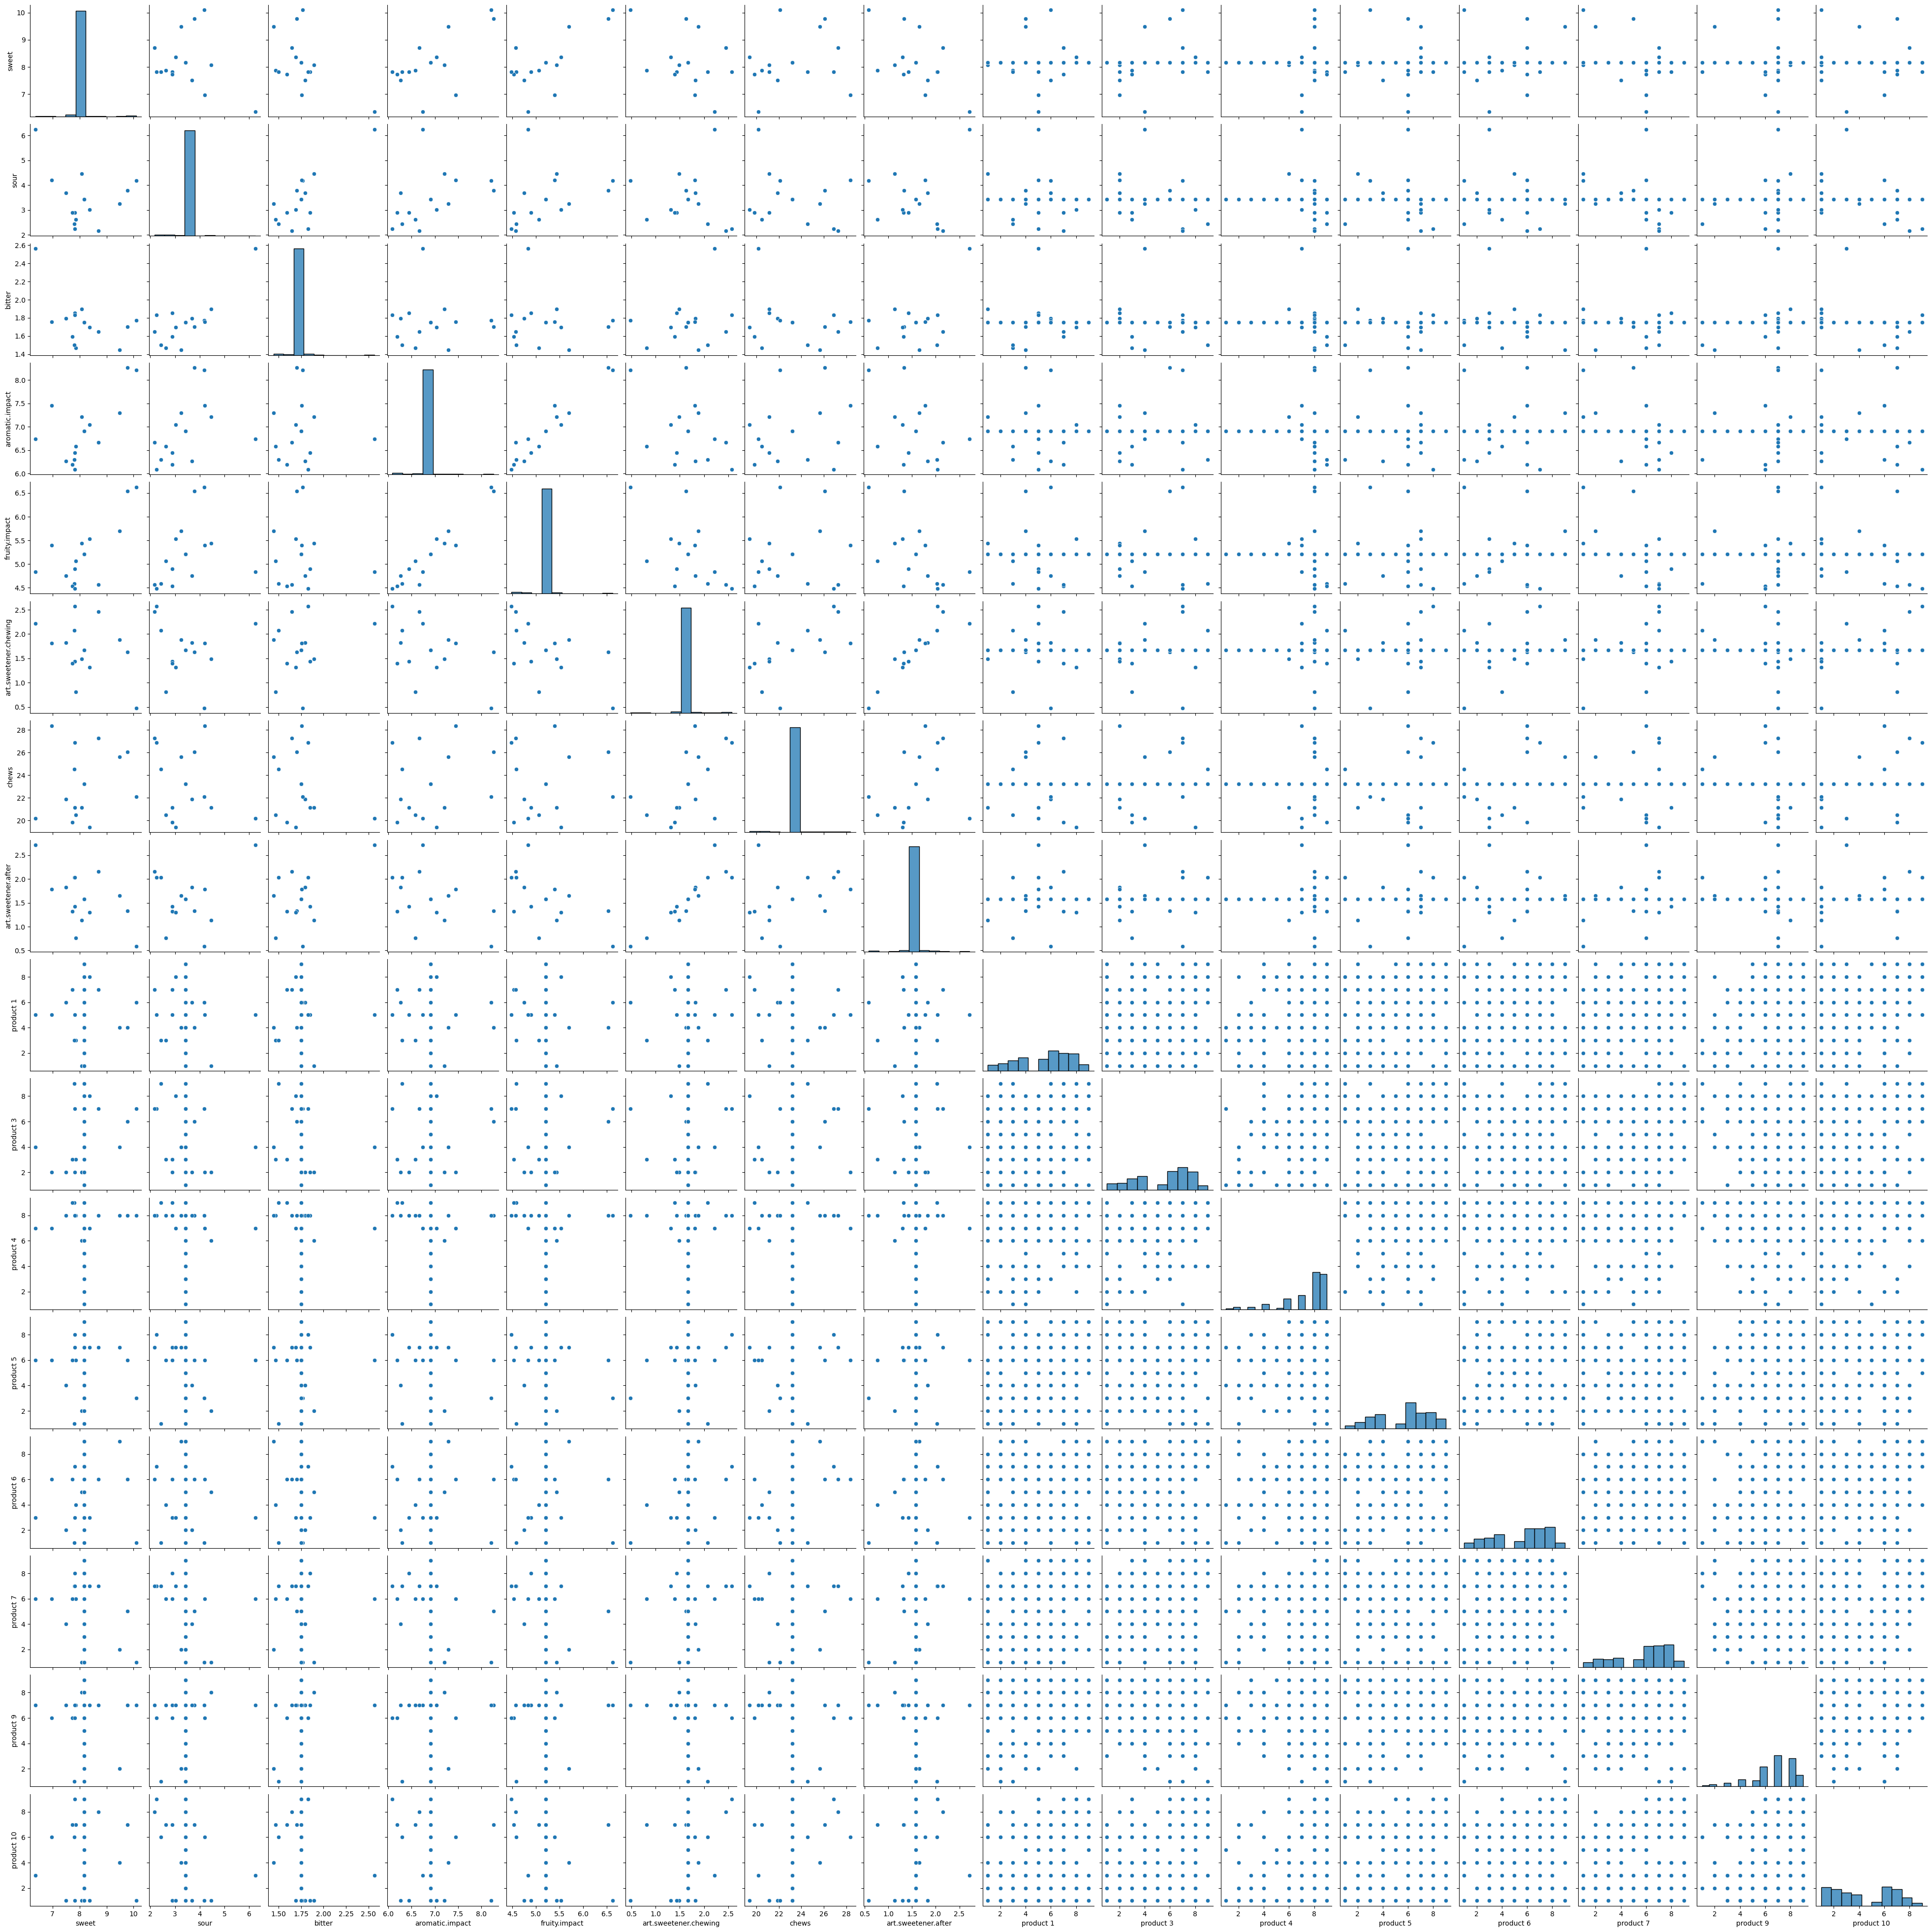

In [60]:
# Visualize relationships between few sensory features and liking scores
sns.pairplot(merged_data[['sweet', 'sour', 'bitter', 'aromatic.impact', 'fruity.impact', 'art.sweetener.chewing','chews','art.sweetener.after','product 1','product 3','product 4','product 5','product 6','product 7','product 9','product 10', ]])  #
plt.show()

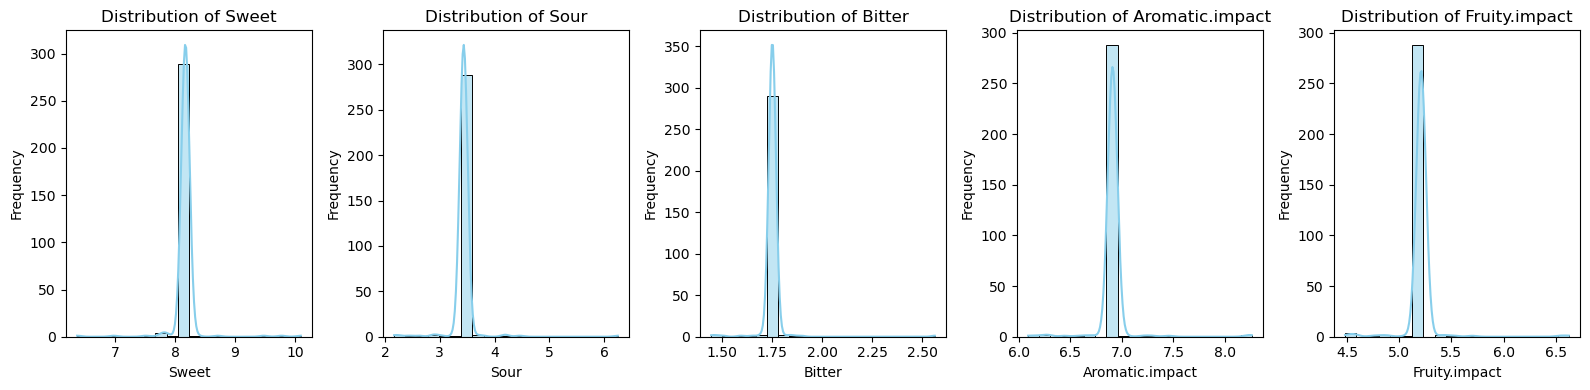

In [62]:
# Visualizing Distributions of Multiple Features of the sensory tab data
features_to_visualize = ['sweet', 'sour', 'bitter', 'aromatic.impact', 'fruity.impact',]
num_features = len(features_to_visualize)

fig, axes = plt.subplots(nrows=1, ncols=num_features, figsize=(16, 4))

for i, feature in enumerate(features_to_visualize):
    sns.histplot(merged_data[feature], bins=20, kde=True, color='skyblue', ax=axes[i])
    axes[i].set_title(f'Distribution of {feature.capitalize()}')
    axes[i].set_xlabel(feature.capitalize())
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


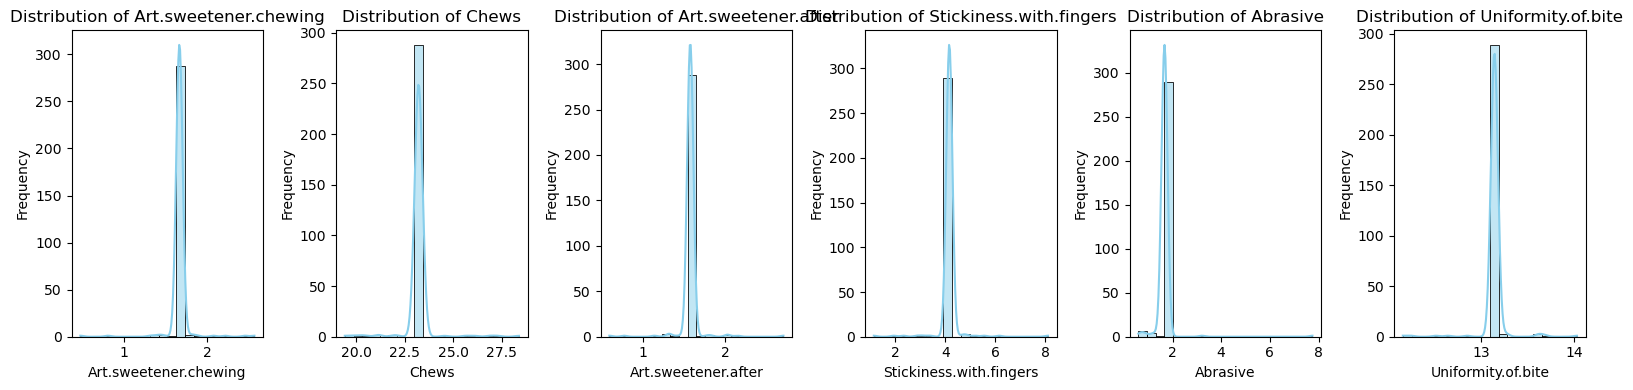

In [63]:
features_to_visualize = ['art.sweetener.chewing','chews','art.sweetener.after','stickiness.with.fingers','abrasive','uniformity.of.bite']
num_features = len(features_to_visualize)

fig, axes = plt.subplots(nrows=1, ncols=num_features, figsize=(16, 4))

for i, feature in enumerate(features_to_visualize):
    sns.histplot(merged_data[feature], bins=20, kde=True, color='skyblue', ax=axes[i])
    axes[i].set_title(f'Distribution of {feature.capitalize()}')
    axes[i].set_xlabel(feature.capitalize())
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

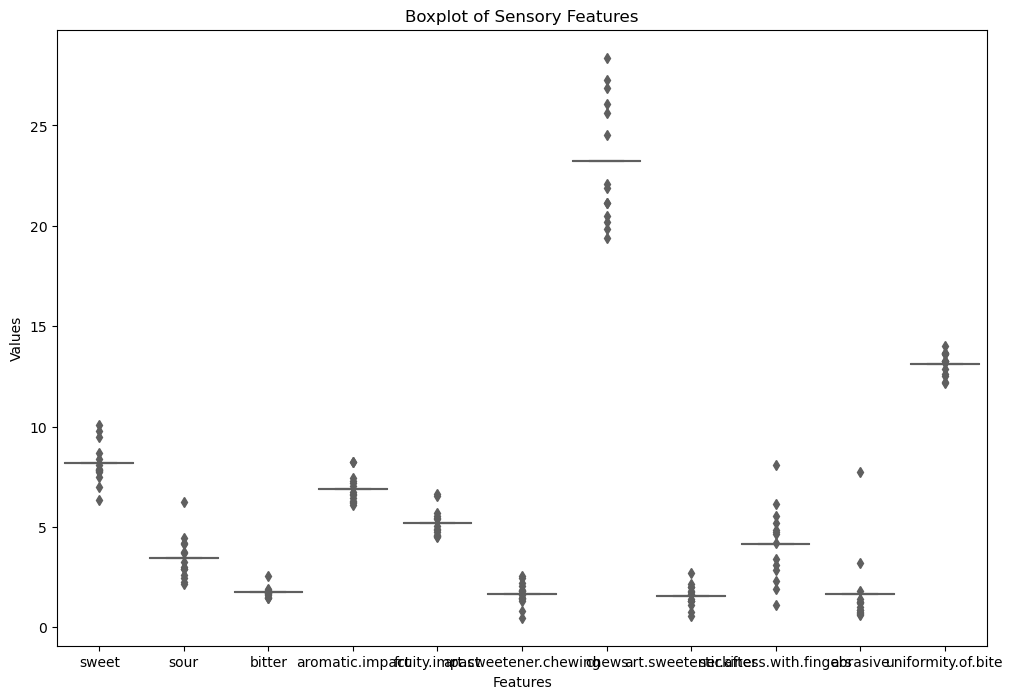

In [67]:
# Boxplot for Multiple Features to discover outliers
plt.figure(figsize=(12,8 ))
sns.boxplot(merged_data[['sweet', 'sour', 'bitter', 'aromatic.impact', 'fruity.impact','art.sweetener.chewing','chews','art.sweetener.after','stickiness.with.fingers','abrasive','uniformity.of.bite']], palette='Set3')
plt.title('Boxplot of Sensory Features')
plt.xlabel('Features')
plt.ylabel('Values')
plt.show()

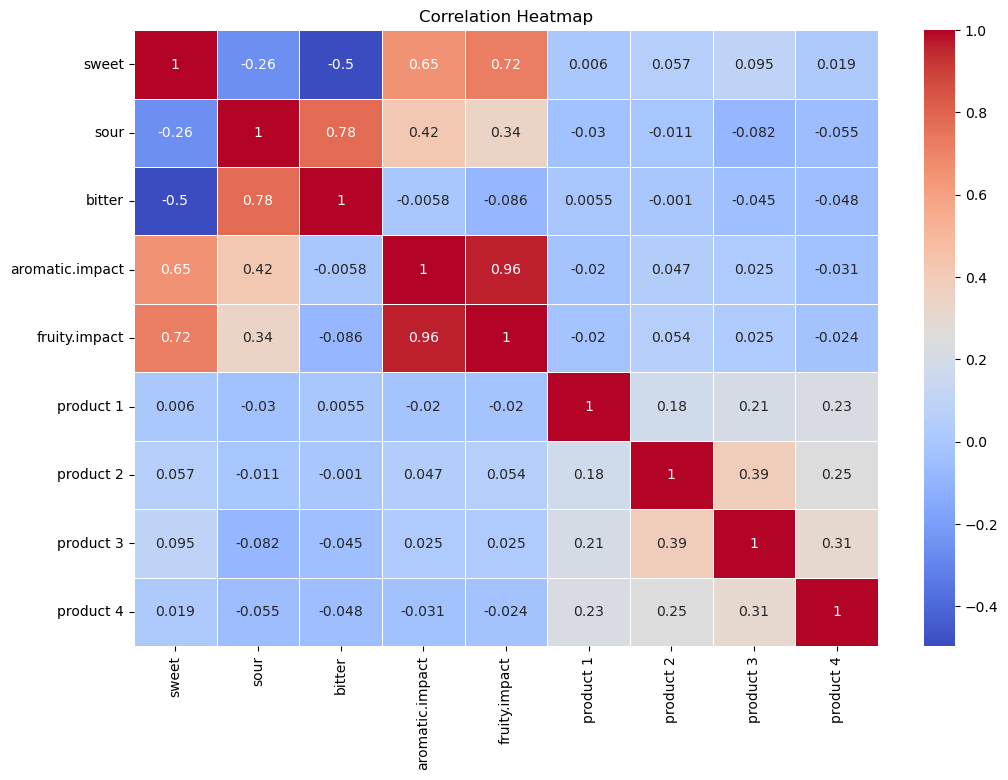

In [68]:
# Explore Correlations between few sensory and overall liking scores
correlation_matrix = merged_data[['sweet', 'sour', 'bitter', 'aromatic.impact', 'fruity.impact', 'product 1','product 2','product 3','product 4']].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

# Explanation:

* Created pairplot to visualize relationships between selected sensory features and liking scores.
* This helped identify potential patterns or trends in the above data.
* Created a histogram to examine the distribution between sensory data providing insights into  the central tendency.
* Understanding this distribution for me, it crucial for modeling.
* Used Boxplot to identify potential outliers in the independent variables.
* Outliers can impact model performance and addressing it appropriately is essential in prediction.
* Computed correlation matrix and visualize it  using heatmap as seen above.
* This help me understand the linear relations between sensory features and target varables which showed some sort of relations.


# Data Preprocessing

In [69]:
# splitting data for modeling
X = merged_data.drop(columns=[ 'product 1','product 2', 'product 3', 'product 4', 'product 5','product 6','product 7','product 8','product 9','product 10','product 11','product 12', 'product 13','product 14'])
y = merged_data[['product 1','product 2', 'product 3', 'product 4','product 5','product 6','product 7','product 8','product 9','product 10','product 11','product 12', 'product 13','product 14']]

# Handling Outliers
# Use z-score to detect and remove outliers
z_scores = zscore(X)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
X = X[filtered_entries]
y = y[filtered_entries]

     

In [70]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Explanation:

* In preprocessing step, seperated the features(X) and target variables (Y).
* Used Z score to detect and remove outliers, and splitted the data into training and test because there were outliers in the features above.
* Z score is a measure that describes how many standard deviations a data point is from the mean of a group of data.
* Also normalized the features using standard scaler, ensuring consistency in scale.

# Model Selection and Training:

In [71]:
# Model Selection - Random Forest and Linear Regression
rf_model = RandomForestRegressor(random_state=42)
lr_model = LinearRegression()

# MultiOutputRegressor wrapper for both models
rf_multi_output_model = MultiOutputRegressor(rf_model)
lr_multi_output_model = MultiOutputRegressor(lr_model)

# Model Training
rf_multi_output_model.fit(X_train_scaled, y_train)
lr_multi_output_model.fit(X_train_scaled, y_train)

MultiOutputRegressor(estimator=LinearRegression())

# Explanation:

* Selected Random Forest model because its one of the top most model in the industry for classification and regression problems and majorly because it generalizes well.
* Also selected Linear Regression because of its simplicity and interpretability. But I am looking out for what it can do in the prediction since we are dealing with a multi target regression problem.
* For best practices sake I  included Multi output Regessor as a wrapper to extend these models to a multi target regression. 

# Model Prediction and Evaluation

In [72]:
# Make Predictions
rf_predictions = rf_multi_output_model.predict(X_test_scaled)
lr_predictions = lr_multi_output_model.predict(X_test_scaled)

# Model Evaluation
rf_mse = mean_squared_error(y_test, rf_predictions)
lr_mse = mean_squared_error(y_test, lr_predictions)

print(f'Random Forest Mean Squared Error: {rf_mse}')
print(f'Linear Regression Mean Squared Error: {lr_mse}')


Random Forest Mean Squared Error: 3.829537775874744
Linear Regression Mean Squared Error: 3.8314026719946206


# Explanation:

* Made predictions using the trained models and evaluated their performance using Mean Squared Error (MSE).
* MSE measures the average squared difference between predicted and actual values, providing a metric for model accuracy.

# Hyperparameter Tuning

In [73]:
#Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2]
}

# Instantiate the GridSearchCV object
grid_search_rf = GridSearchCV(RandomForestRegressor(), param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search_rf.fit(X_train_scaled, y_train)

# Get the best hyperparameters
best_rf_params = grid_search_rf.best_params_

# Train the Random Forest model with the best hyperparameters
best_rf_model = RandomForestRegressor(**best_rf_params)
best_rf_model.fit(X_train_scaled, y_train)

# Evaluate the performance of the tuned Random Forest model
tuned_rf_predictions = best_rf_model.predict(X_test_scaled)
tuned_rf_mse = mean_squared_error(y_test, tuned_rf_predictions)
print(f'Tuned Random Forest Mean Squared Error: {tuned_rf_mse}')

Tuned Random Forest Mean Squared Error: 3.8314964737357733


In [74]:
# Model Comparison
print(f'Random Forest Mean Squared Error: {tuned_rf_mse}')
print(f'Linear Regression Mean Squared Error: {lr_mse}')


Random Forest Mean Squared Error: 3.8314964737357733
Linear Regression Mean Squared Error: 3.8314026719946206


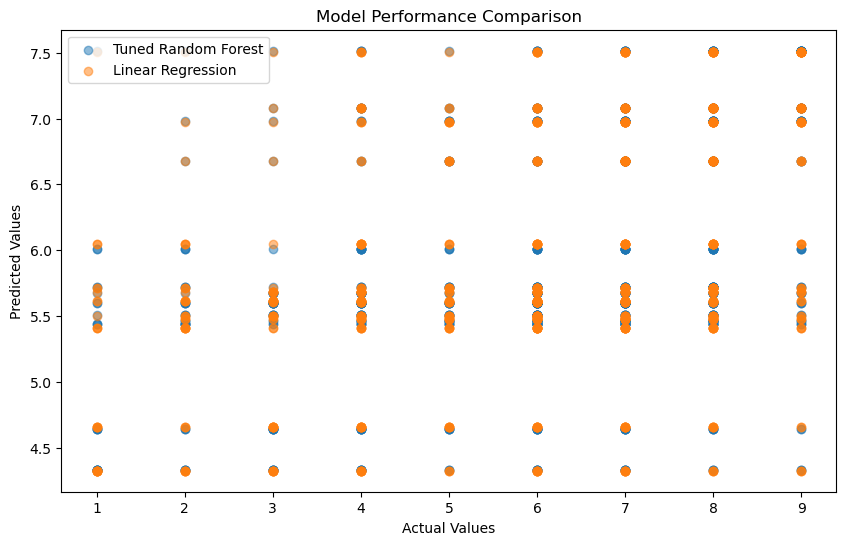

In [75]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, tuned_rf_predictions, alpha=0.5, label='Tuned Random Forest')
plt.scatter(y_test, lr_predictions, alpha=0.5, label='Linear Regression')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Model Performance Comparison')
plt.legend()
plt.show()


# Explanation:

* Tried tuning the RF model for better performance based on the evaluation Metrics.
* The MSE for the Random Forest model is relatively low.
* This suggests that, on average, the squared difference between the predicted and actual values is small.
* Lower MSE indicates that the Random Forest model is making predictions that are close to the actual values.
* The MSE for the Linear Regression model is lower too.
* This indicates that, on average, the squared difference between the predicted and actual values is fairly similar to the Random Forest model.

In summary, based on the MSE values:

The Random Forest model  and Linear model both performed well, providing more accurate predictions on average.

# Project Summary / Documentation

Overview:

The goal of this project was to develop a model capable of predicting consumer liking scores for 14 different products based on their sensory profiles. The data encompassed sensory attributes and overall liking scores provided by consumers, and the task involved creating a robust predictive model.

Key Steps and Observations:
1. Data Exploration:

* The initial exploration revealed a diverse range of sensory features, capturing nuances like sweetness, sourness, and aromatic impact.
* The liking scores exhibited variations, indicating the need for a model to capture the underlying patterns.

2. Model Selection and Training:

* Two models were chosen for their effectiveness in regression tasks: Random Forest and Linear Regression.
* The models were trained on a subset of the data, and the performance was evaluated using Mean Squared Error.

3. Hyperparameter Tuning:

* Hyperparameter tuning was performed for the Random Forest model to optimize its performance.
* The best-tuned model demonstrated improved predictive accuracy
* Same for linear regression wrapped in Multi output Regressor for performance.

Findings and Implications:

1. Feature Importance:

* Sweetness,aromatic impact, etc, emerged as particularly influential factors in predicting liking scores.
* Understanding these key contributors can guide product development to emphasize desired sensory characteristics.

2. Model Performance:

* Both Random Forest and Linear Regression models provided great predictions.
* The choice between models  depends on interpretability requirements, with Linear Regression offering more straightforward insights.

3. Room for Improvement:

* The dataset could benefit from additional consumer demographic information to enhance model robustness.
* Further exploration into non-linear relationships or interaction effects between sensory features could refine predictions.

4. Visualization and Interpretability:

* Visualizations like pairplots proved valuable in understanding feature relationships.
* For stakeholders, clear visualizations can be essential in conveying complex relationships in an understandable manner, that it is the reason it was included for easy understanding.

5. Future Steps:

* Continuous model monitoring and retraining as more data becomes available can ensure the model's relevancy.
* Experimentation with ensemble models or more advanced techniques could further improve prediction accuracy.

Conclusion:

In summary, this project successfully developed predictive models for consumer liking scores based on sensory attributes. The findings provide actionable insights for product development, and ongoing refinement of models and data collection strategies could enhance predictive capabilities. The project demonstrates the potential for data-driven decision-making in optimizing product attributes to meet consumer preferences.

# Thank you!